# Tentative de tests version finale de la viz secondaire, en ayant avec et sans ports francs

In [1]:
from poitousprint import Toflit
from vega import VegaLite
import pandas as pd
from operator import itemgetter # to sort lists

toflit_client = Toflit()

def prepare_flow(flow):
    f = flow.copy()
    if f['export_import'] == 'Imports' or f['export_import'] == 'import':
        f['export_import'] = 'Imports'
    elif f['customs_region'] == '' or f['customs_region'] == 'National':
        f['customs_region_simpl'] = 'National'
    if f['customs_region'] == 'La Rochelle':
        f['customs_region_simpl'] = 'La Rochelle'
    else:
        f['customs_region_simpl'] = 'Autre direction'
    f['value'] = float(f['value']) if f['value'] != '' else 0
    return f

def clean_flow(flow):
    f = flow.copy()
    abs_map = total_exports_per_direction if f['export_import'] == 'Exports' else total_imports_per_direction
    f['value_rel_per_direction'] = f['value'] / abs_map[f['customs_region_simpl']]
    return f   

def remove_ports_francs_from_flows(flows):
    # return [f for f in flows if f['partner_grouping'] != 'France']
    flows_without_ports_francs = []
    i = 0
    for flow in flows:
        if flow['partner_grouping'] != 'France':
            i += 1
            flows_without_ports_francs.append(flow)
    print("nombre de pas ports francs trouvés : ", i)
    return flows_without_ports_francs
            
def aggregate_flows_by_product(flows):
    flows_aggregated_by_product = {}
    # je veux construire un dict par produit, en distinguant LR / pas LR
    
    for flow in flows:
        if flow['product_revolutionempire'] not in flows_aggregated_by_product:
            flows_aggregated_by_product[flow['product_revolutionempire']] = {
                'product':flow['product_revolutionempire'],
                'exports_la_rochelle': 0,
                'exports_toute_france':0,
                }
    # à la fin pour chaque produit je sommerais le total export pour calculer du relatif  
        if flow['customs_region_simpl'] == 'La Rochelle':
            flows_aggregated_by_product[flow['product_revolutionempire']]['exports_la_rochelle'] += flow['value']
        flows_aggregated_by_product[flow['product_revolutionempire']]['exports_toute_france'] += flow['value']

    return flows_aggregated_by_product

def aggregate_flows_by_product_removing_ports_francs(flows):
    flows_aggregated_by_product = {}
    # je veux construire un dict par produit, en distinguant LR / pas LR
    i = 0
    
    for flow in flows:
        if flow['product_revolutionempire'] not in flows_aggregated_by_product:
            flows_aggregated_by_product[flow['product_revolutionempire']] = {
                'product':flow['product_revolutionempire'],
                'exports_la_rochelle': 0,
                'exports_toute_france':0,
                }
    # à la fin pour chaque produit je sommerais le total export pour calculer du relatif  
        if flow['partner_grouping'] != 'France':
            i += 1
            if flow['customs_region_simpl'] == 'La Rochelle':
                flows_aggregated_by_product[flow['product_revolutionempire']]['exports_la_rochelle'] += flow['value']
            flows_aggregated_by_product[flow['product_revolutionempire']]['exports_toute_france'] += flow['value']

    print("nombre de flows considérés avec ports francs : ", len(flows), " \nsans ports francs : ", i)
    return flows_aggregated_by_product

## 1789

In [2]:
total_exports_per_direction = {}
total_imports_per_direction = {}

# flows_1750  = toflit_client.get_flows(year=1750, best_guess_region_prodxpart='1')
flows_1789 = toflit_client.get_flows(year=1789, best_guess_region_prodxpart='1')
# flows_1789_without_ports_francs = [remove_ports_francs_from_flows(flows_1789)]

for f in flows_1789:
    flow = prepare_flow(f)
    if flow['export_import'] == 'Imports':
        if flow['customs_region_simpl'] not in total_imports_per_direction:
            total_imports_per_direction[flow['customs_region_simpl']] = 0
        total_imports_per_direction[flow['customs_region_simpl']] += flow['value']
    else:
        if flow['customs_region_simpl'] not in total_exports_per_direction:
            total_exports_per_direction[flow['customs_region_simpl']] = 0
        total_exports_per_direction[flow['customs_region_simpl']] += flow['value']
        
# flows_1750 = [clean_flow(prepare_flow(f)) for f in flows_1750]
flows_1789 = [clean_flow(prepare_flow(f)) for f in flows_1789]

# aggregation des flux par produit
product_exports_values_per_direction_1789 = aggregate_flows_by_product(flows_1789)
product_exports_values_per_direction_1789_without_ports_francs = aggregate_flows_by_product_removing_ports_francs(flows_1789)

# calcul de la part de chaque produit dans les exports totaux
total_exports_la_rochelle_1789 = 0
total_exports_toute_france_1789 = 0
total_exports_la_rochelle_1789_without_ports_francs = 0
total_exports_toute_france_1789_without_ports_francs = 0


for product, values in product_exports_values_per_direction_1789.items():
    total_exports_la_rochelle_1789 += values['exports_la_rochelle']
    total_exports_toute_france_1789 += values['exports_toute_france']

for product, values in product_exports_values_per_direction_1789.items():
    values['exports_rel_la_rochelle'] = values['exports_la_rochelle'] / total_exports_la_rochelle_1789
    values['exports_rel_toute_france'] = values['exports_toute_france'] / total_exports_toute_france_1789
    
for product, values in product_exports_values_per_direction_1789_without_ports_francs.items():
    total_exports_la_rochelle_1789_without_ports_francs += values['exports_la_rochelle']
    total_exports_toute_france_1789_without_ports_francs += values['exports_toute_france']

for product, values in product_exports_values_per_direction_1789_without_ports_francs.items():
    values['exports_rel_la_rochelle'] = values['exports_la_rochelle'] / total_exports_la_rochelle_1789_without_ports_francs
    values['exports_rel_toute_france'] = values['exports_toute_france'] / total_exports_toute_france_1789_without_ports_francs

# ordonner en mettant en premier les produits les plus importants pour La Rochelle
sorted_product_exports_values_per_direction_1789 = sorted(product_exports_values_per_direction_1789.values(), key=itemgetter('exports_rel_la_rochelle'), reverse=True)
sorted_product_exports_values_per_direction_1789_without_ports_francs = sorted(product_exports_values_per_direction_1789_without_ports_francs.values(), key=itemgetter('exports_rel_la_rochelle'), reverse=True)

# reformatter les données sous la forme d'un ensemble de dicts : un dict par produit pour La Rochelle et un dict par produit pour l'ensemble de la France
final_vega_data_1789 = []
i = 0
for values in sorted_product_exports_values_per_direction_1789:
    
    final_vega_data_1789.append({
        "product" : values['product'],
        "comparaison de la direction de La Rochelle à la moyenne nationale" : 'direction de La Rochelle',
        "value_rel_per_direction" : values['exports_rel_la_rochelle'],
        "order":i
    })
    
    final_vega_data_1789.append({
        "product" : values['product'],
        "comparaison de la direction de La Rochelle à la moyenne nationale" : "France (moyenne)",
        "value_rel_per_direction" : values['exports_rel_toute_france'],
        "order":i
    })
    
    i += 1
    
final_vega_data_1789_without_ports_francs = []
i = 0
for values in sorted_product_exports_values_per_direction_1789_without_ports_francs:
    
    final_vega_data_1789_without_ports_francs.append({
        "product" : values['product'],
        "comparaison de la direction de La Rochelle à la moyenne nationale" : 'direction de La Rochelle',
        "value_rel_per_direction" : values['exports_rel_la_rochelle'],
        "order":i
    })
    
    final_vega_data_1789_without_ports_francs.append({
        "product" : values['product'],
        "comparaison de la direction de La Rochelle à la moyenne nationale" : "France (moyenne)",
        "value_rel_per_direction" : values['exports_rel_toute_france'],
        "order":i
    })
    
    i += 1

nombre de flows considérés avec ports francs :  28583  
sans ports francs :  22932


In [3]:
# on abandonne la version avec ports francs
"""
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Produits dont les valeurs d'exports sont les plus importantes pour La Rochelle en 1789",
  "height": {"step": 60},
  "mark": "bar",
  "encoding": {
    "row": {
      "field": "product", 
      "type": "nominal", 
      "spacing": 10, 
      "sort":{"field" : "order"}, 
      "header": {"labelAngle": -90,
                 "labelAlign": "right"
                }
    },
    "x": {
      "aggregate": "sum", "field": "value_rel_per_direction",
      "title": "Part du produit dans le total des exports (en valeur)",
      "axis": {"orient": "top"},
      "type":"quantitative"
    },
    "y": {
      "field": "comparaison de la direction de La Rochelle à la moyenne nationale",
      "axis": {"title": ""},
      "type":"nominal",
      "sort":{"order":"descending"}
    },
    "color": {
      "field": "comparaison de la direction de La Rochelle à la moyenne nationale",
      "scale": {"range": ["#675193", "#ca8861"]}
    }
  },
  "config": {
    "view": {"stroke": "transparent"},
    "axis": {"domainWidth": 1}
  }
}, pd.DataFrame(final_vega_data_1789))
""" 

'\nVegaLite({\n  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",\n  "title": "Produits dont les valeurs d\'exports sont les plus importantes pour La Rochelle en 1789",\n  "height": {"step": 60},\n  "mark": "bar",\n  "encoding": {\n    "row": {\n      "field": "product", \n      "type": "nominal", \n      "spacing": 10, \n      "sort":{"field" : "order"}, \n      "header": {"labelAngle": -90,\n                 "labelAlign": "right"\n                }\n    },\n    "x": {\n      "aggregate": "sum", "field": "value_rel_per_direction",\n      "title": "Part du produit dans le total des exports (en valeur)",\n      "axis": {"orient": "top"},\n      "type":"quantitative"\n    },\n    "y": {\n      "field": "comparaison de la direction de La Rochelle à la moyenne nationale",\n      "axis": {"title": ""},\n      "type":"nominal",\n      "sort":{"order":"descending"}\n    },\n    "color": {\n      "field": "comparaison de la direction de La Rochelle à la moyenne nationale",\n      

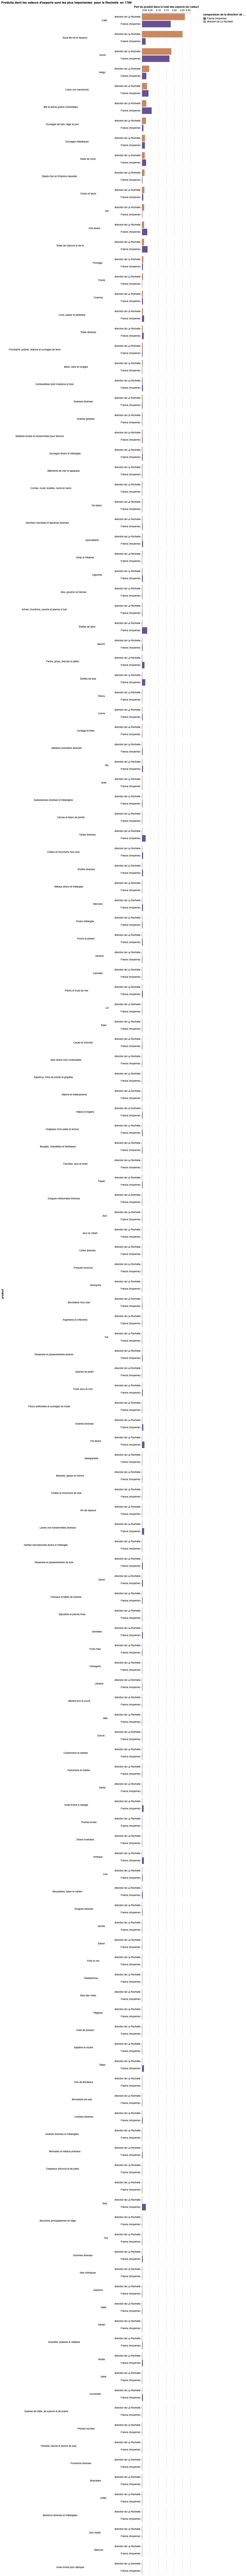

In [4]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Produits dont les valeurs d'exports sont les plus importantes  pour la Rochelle  en 1789",
  "height": {"step": 30},
  "mark": "bar",
  "encoding": {
    "row": {
      "field": "product", 
      "type": "nominal", 
      "spacing": 10, 
      "sort":{"field" : "order"}, 
      "header": {"labelAngle": 0,
                 "labelAlign": "right"
                }
    },
    "x": {
      "aggregate": "sum", "field": "value_rel_per_direction",
      "title": "Part du produit dans le total des exports (en valeur)",
      "axis": {"orient": "top"},
      "type":"quantitative"
    },
    "y": {
      "field": "comparaison de la direction de La Rochelle à la moyenne nationale",
      "axis": {"title": ""},
      "type":"nominal",
      "sort":{"order":"descending"}
    },
    "color": {
      "field": "comparaison de la direction de La Rochelle à la moyenne nationale",
      "scale": {"range": ["#675193", "#ca8861"]}
    }
  },
  "config": {
    "view": {"stroke": "transparent"},
    "axis": {"domainWidth": 1}
  }
}, pd.DataFrame(final_vega_data_1789_without_ports_francs))

## 1750

In [5]:
total_exports_per_direction = {}
total_imports_per_direction = {}

flows_1750  = toflit_client.get_flows(year=1750, best_guess_region_prodxpart='1')


for f in flows_1750:
    flow = prepare_flow(f)
    if flow['export_import'] == 'Imports':
        if flow['customs_region_simpl'] not in total_imports_per_direction:
            total_imports_per_direction[flow['customs_region_simpl']] = 0
        total_imports_per_direction[flow['customs_region_simpl']] += flow['value']
    else:
        if flow['customs_region_simpl'] not in total_exports_per_direction:
            total_exports_per_direction[flow['customs_region_simpl']] = 0
        total_exports_per_direction[flow['customs_region_simpl']] += flow['value']
        
flows_1750 = [clean_flow(prepare_flow(f)) for f in flows_1750]

# aggregation des flux par produit
product_exports_values_per_direction_1750 = aggregate_flows_by_product(flows_1750)
product_exports_values_per_direction_1750_without_ports_francs = aggregate_flows_by_product_removing_ports_francs(flows_1750)

# calcul de la part de chaque produit dans les exports totaux
total_exports_la_rochelle_1750 = 0
total_exports_toute_france_1750 = 0
total_exports_la_rochelle_1750_without_ports_francs = 0
total_exports_toute_france_1750_without_ports_francs = 0


for product, values in product_exports_values_per_direction_1750.items():
    total_exports_la_rochelle_1750 += values['exports_la_rochelle']
    total_exports_toute_france_1750 += values['exports_toute_france']

for product, values in product_exports_values_per_direction_1750.items():
    values['exports_rel_la_rochelle'] = values['exports_la_rochelle'] / total_exports_la_rochelle_1750
    values['exports_rel_toute_france'] = values['exports_toute_france'] / total_exports_toute_france_1750
    
for productt_exports_values_per_direction_1750_without_ports_francs_without_ports_francs, values in product_exports_values_per_direction_1750_without_ports_francs.items():
    total_exports_la_rochelle_1750_without_ports_francs += values['exports_la_rochelle']
    total_exports_toute_france_1750_without_ports_francs += values['exports_toute_france']

for product, values in product_exports_values_per_direction_1750_without_ports_francs.items():
    values['exports_rel_la_rochelle'] = values['exports_la_rochelle'] / total_exports_la_rochelle_1750_without_ports_francs
    values['exports_rel_toute_france'] = values['exports_toute_france'] / total_exports_toute_france_1750_without_ports_francs

# ordonner en mettant en premier les produits les plus importants pour La Rochelle
sorted_product_exports_values_per_direction_1750 = sorted(product_exports_values_per_direction_1750.values(), key=itemgetter('exports_rel_la_rochelle'), reverse=True)
sorted_product_exports_values_per_direction_1750_without_ports_francs = sorted(product_exports_values_per_direction_1750_without_ports_francs.values(), key=itemgetter('exports_rel_la_rochelle'), reverse=True)

# reformatter les données sous la forme d'un ensemble de dicts : un dict par produit pour La Rochelle et un dict par produit pour l'ensemble de la France
final_vega_data_1750 = []
i = 0
for values in sorted_product_exports_values_per_direction_1750:
    
    final_vega_data_1750.append({
        "product" : values['product'],
        "comparaison de la direction de La Rochelle à la moyenne nationale" : 'La Rochelle',
        "value_rel_per_direction" : values['exports_rel_la_rochelle'],
        "order":i
    })
    
    final_vega_data_1750.append({
        "product" : values['product'],
        "comparaison de la direction de La Rochelle à la moyenne nationale" : "France (moyenne)",
        "value_rel_per_direction" : values['exports_rel_toute_france'],
        "order":i
    })
    
    i += 1
    
final_vega_data_1750_without_ports_francs = []
i = 0
for values in sorted_product_exports_values_per_direction_1750_without_ports_francs:
    
    final_vega_data_1750_without_ports_francs.append({
        "product" : values['product'],
        "comparaison de la direction de La Rochelle à la moyenne nationale" : 'direction de La Rochelle',
        "value_rel_per_direction" : values['exports_rel_la_rochelle'],
        "order":i
    })
    
    final_vega_data_1750_without_ports_francs.append({
        "product" : values['product'],
        "comparaison de la direction de La Rochelle à la moyenne nationale" : "France (moyenne)",
        "value_rel_per_direction" : values['exports_rel_toute_france'],
        "order":i
    })
    
    i += 1

nombre de flows considérés avec ports francs :  12490  
sans ports francs :  12490


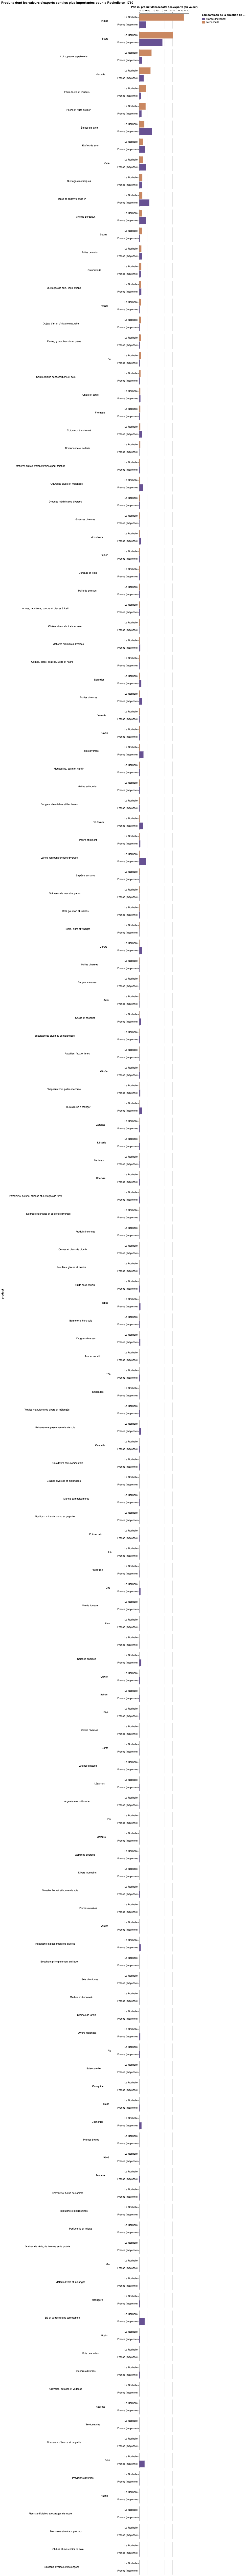

In [6]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Produits dont les valeurs d'exports sont les plus importantes pour la Rochelle en 1750",
  "height": {"step": 30},
  "mark": "bar",
  "encoding": {
    "row": {
      "field": "product", 
      "type": "nominal", 
      "spacing": 10, 
      "sort":{"field" : "order"}, 
      "header": {"labelAngle": 0,
                 "labelAlign": "right"
                }
    },
    "x": {
      "aggregate": "sum", "field": "value_rel_per_direction",
      "title": "Part du produit dans le total des exports (en valeur)",
      "axis": {"orient": "top"},
      "type":"quantitative"
    },
    "y": {
      "field": "comparaison de la direction de La Rochelle à la moyenne nationale",
      "axis": {"title": ""},
      "type":"nominal",
      "sort":{"order":"descending"}
    },
    "color": {
      "field": "comparaison de la direction de La Rochelle à la moyenne nationale",
      "scale": {"range": ["#675193", "#ca8861"]}
    }
  },
  "config": {
    "view": {"stroke": "transparent"},
    "axis": {"domainWidth": 1}
  }
}, pd.DataFrame(final_vega_data_1750))